# A Toy Example for Model Calibration Using the Lotka-Volterra System 

- Description: Optimizing a system of ordinary differential equations to synthetic data
- Author: Caroline Larkin
- Date: Fall 2022

## Set-Up Model

### Load relevant packages

In [1]:
import numpy as np
import scipy as sp
from scipy.integrate import odeint
import pandas as pd
import matplotlib.pyplot as plt
import copy

import pypesto
import pypesto.engine as eng
import pypesto.visualize as visualize
import pypesto.optimize as optimize
import pypesto.profile as profile
import pypesto.sample as sample
import pypesto.store as store
import os 

SEED=123456
np.random.seed(seed=SEED)
engine = eng.MultiProcessEngine(n_procs=os.cpu_count())

print(os.cpu_count())

N_TIME_PTS = 50 # num time points used to create synthetic dataset
                # total num data points = N_TIME_PTS * 2
LOG_PARAM = False # SET TO FALSE, NEED TO FIX BUG WHEN TRUE
LOG_ERROR = False
PCT_NOISE = 0.01 # % Gaussian noise (range is 0-1)

8


### Define Lotka-Volterra model class and helper functions

In [2]:
class model:
    def __init__(self, alpha=1.1, beta=0.4, delta=0.1, gamma=0.4):
        # prey birth rate
        self.a = alpha
        # prey death rate
        self.b = beta
        # predator birth rate 
        self.d = delta
        # predator death rate
        self.g = gamma
    
    def sys_ode(self, y, t):
        prey, pred = y
        d_prey = (self.a * prey) - (self.b * prey * pred)
        d_pred = (self.d * prey * pred) - (self.g *pred)
        return np.array([d_prey, d_pred])
        
    def solve_sys(self, init_cond=[10.0,10.0], sim_duration=50, sim_n_steps=501):
        ts = np.linspace(0, sim_duration, sim_n_steps)
        res = odeint(self.sys_ode, init_cond, ts)
        return ts, res
    
def gaussian_noise(x,std, mu=0):
    noise = np.random.normal(mu, std, size = x.shape)
    x_noisy = x + noise
    return x_noisy 

### Show true solution

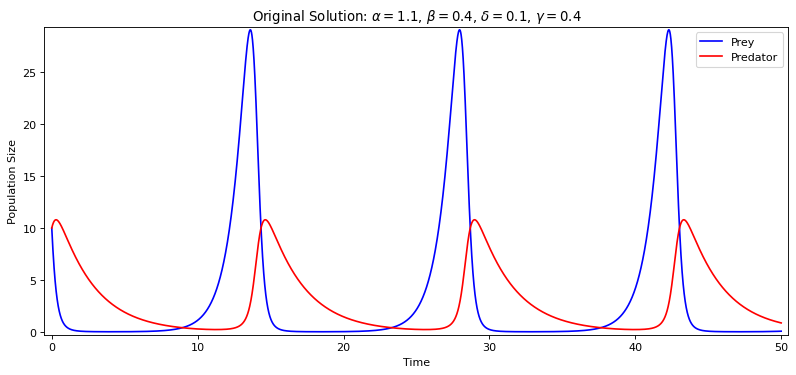

In [3]:
mod = model()
ts, res = mod.solve_sys(sim_n_steps=5001)
plt.figure(figsize=(12,5), dpi=80)
plt.plot(ts, res[:, 0], 'b', label='Prey')
plt.plot(ts, res[:, 1], 'r', label='Predator');
plt.title('Original Solution: $\\alpha={}$, $\\beta={}$, $\delta={}$, $\gamma={}$'.format(mod.a, mod.b, mod.d, mod.g)); 
plt.xlabel('Time'); plt.ylabel('Population Size');
plt.margins(x=0.01, y=0.01);
plt.legend(); 

## Create and plot synthetic dataset used for model calibration

### Create synthetic dataset with Gaussian noise defined by `pct` variable

In [4]:
ts_data, res = mod.solve_sys(sim_n_steps=501)
# add noise
std = PCT_NOISE * np.std(res, axis=0)
res_noisy = gaussian_noise(res, std)
res_noisy[res_noisy < 0] = 0

# Randomly select n time points 
idxs = np.sort(np.random.choice(ts_data.shape[0], N_TIME_PTS, replace=False))
ts_data = ts_data[idxs]
res_noisy = res_noisy[idxs, :]

df = pd.DataFrame()
df['Time'] = ts_data
df['Prey'] = res_noisy[:, 0]
df['Predator'] = res_noisy[:, 1]
df.to_csv('synthetic_lv_data.csv', index=False)

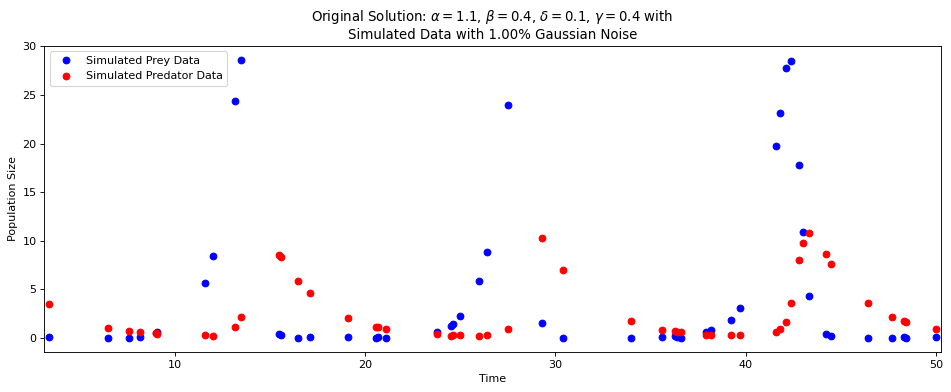

In [5]:
plt.figure(figsize=(12,5), dpi=80)
plt.plot(ts_data, res_noisy[:, 0], 'bo', label='Simulated Prey Data')
plt.plot(ts_data, res_noisy[:, 1], 'ro',label='Simulated Predator Data')
plt.margins(x=0.005, y=0.05)
plt.legend(); plt.xlabel('Time'); plt.ylabel('Population Size')
plt.title('Original Solution: $\\alpha={}$, $\\beta={}$, $\delta={}$, $\gamma={}$ with \nSimulated Data with {:.2f}% Gaussian Noise'.format(mod.a, mod.b, mod.d, mod.g, PCT_NOISE*100))
plt.tight_layout();

## Model Calibration Set-Up

### Define cost function and prior information

In [6]:
def log_likelihood(params):
    """Returns the negative sum of square errors

    Args:
        params (array): proposed parameters
        x (array): data set times
        y (array): _description_
        model (model object): _description_
    """
    candidate_params = copy.deepcopy(params)
    if LOG_PARAM:
        candidate_params = [10**x for x in params]
    
    new_mod = model(*candidate_params)
    ts_guess, y_guess = new_mod.solve_sys()
    if np.isnan(y_guess).any():
        return np.inf
    
    t_idxs = np.where(np.isin(ts_guess, ts_data))[0]
    if t_idxs.shape[0] != ts_data.shape[0]:
        raise Exception('Not all the times outputted by candidate parameter system are found in data time points! We cannot calculate error!')
    #for a, b in zip(ts_data, ts_guess[t_idxs]):
    #    print(a, b, a==b)
    
    y_guess_short = y_guess[t_idxs, :]
    sse = np.sum(np.square(res_noisy - y_guess_short))
    if LOG_ERROR:
        sse = np.log10(sse)
    return sse

# Sanity check
sse = log_likelihood([1.1, 0.4, 0.1, 0.4])
print(sse)
bad_sse = log_likelihood([100, 0.4, 0.1, 0.4])
print(bad_sse)

# Currently not used 
def log_prior(params):
    new_params = copy.deepcopy(params)
    bnds = [(0.11, 11), (0.04, 4), (0.01, 1), (0.04, 4)]
    if LOG_PARAM:
        bnds = np.log10(bnds)
        new_params = [10 ** x for x in params]
    if np.all([y[0]<x<y[1] for x, y in zip(new_params,bnds)]):
        return 0
    return np.inf

0.31597096959407966
101001.32272845085


### Create pyPESTO objects used in optimization

In [7]:
neg_log_likelihood = pypesto.Objective(fun=log_likelihood)
neg_log_prior = pypesto.Objective(fun=log_prior)
neg_log_posterior = pypesto.objective.AggregatedObjective(
    [neg_log_likelihood, neg_log_prior]
)

bnds = [(0.11, 11), (0.04, 4), (0.01, 1), (0.04, 4)]
#bnds = [(0.5,2), (0.2, 0.8), (0.05, 0.2), (0.2, 0.8)]
if LOG_PARAM:
    bnds = np.log10(bnds)

lb = [x[0] for x in bnds]; ub = [x[1] for x in bnds];
problem = pypesto.Problem(
    objective=neg_log_likelihood,
    lb=lb,
    ub=ub,
)

## Model Calibration

### First run local optimization using Nelder-Mead algorithm to find a decent guess of parameter values to be used for MCMC

In [8]:
history_options = pypesto.HistoryOptions(trace_record=True)
optim_nm = optimize.ScipyOptimizer(
    method='Powell', 
    options={'maxiter':int(1e4)}
)

bnd_result = optimize.minimize(
    problem=problem,
    optimizer=optim_nm,
    n_starts=1,
    filename=None, engine=engine,
    progress_bar=True, history_options=history_options
)

Performing parallel task execution on 1 processes.
100%|██████████| 1/1 [00:00<00:00, 1217.86it/s]


<AxesSubplot:title={'center':'Estimated parameters'}, xlabel='Parameter value', ylabel='Parameter'>

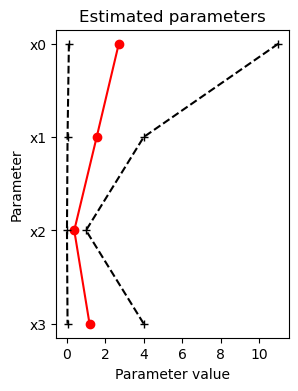

In [9]:
visualize.parameters(bnd_result, size=(3,4))

### Run simple MCMC

In [10]:
n_samps = 500000
sampler = sample.ParallelTemperingSampler(internal_sampler=sample.MetropolisSampler(), n_chains=1)
bnd_result = sample.sample(
    problem=problem, 
    n_samples=n_samps, 
    result=bnd_result, 
    sampler=sampler,
    filename=None
)
elapsed_time = bnd_result.sample_result.time
print(f"Elapsed time: {round(elapsed_time,2)}")

print(bnd_result.sample_result.keys())
print(bnd_result.sample_result['burn_in'])

 20%|██        | 102396/500000 [05:37<25:08, 263.56it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2410004939959D+02   r2 =  0.1528867326469D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2410004939959D+02   r2 =  0.1528867326469D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2410004939959D+02   r2 =  0.1528867326469D-14


100%|██████████| 500000/500000 [17:56<00:00, 464.27it/s] 
Elapsed time: 1079.5679243739999


Elapsed time: 1079.57
dict_keys(['trace_x', 'trace_neglogpost', 'trace_neglogprior', 'betas', 'burn_in', 'time', 'auto_correlation', 'effective_sample_size', 'message'])
None


## Save results to HDF5 file

In [12]:
store.write_result(bnd_result, 'toytest_%d.hdf5'%n_samps, overwrite=True, optimize=True, problem=True, sample=True)

## Visualize (and optionally load) results

In [13]:
results_fn = 'toytest_%d.hdf5'%n_samps#'../../../test.hdf5'
result = store.read_result(results_fn, problem=True, optimize=True, sample=True)
noisy_data = pd.read_csv("synthetic_lv_data.csv")
ts_data = noisy_data.values[:, 0]
res_noisy = noisy_data.values[:, 1:]

This problem is not to be used without a separately created objective.


In [14]:
optim_df = result.optimize_result.as_dataframe()
optim_df

,id,x,fval,grad,hess,res,sres,n_fval,n_grad,n_hess,n_res,n_sres,x0,fval0,history,exitflag,time,message,optimizer
0,0,"[2.704684482196212, 1.5550711437325546, 0.3887...",4178.886533,None,None,None,None,265,0,0,0,0,"[8.034868032493883, 3.0291212610793377, 0.7260...",7306.016843,None,0,7.212046,Optimization terminated successfully.,<ScipyOptimizer method=Powell options={'maxite...


In [15]:
local_optim = optim_df.iloc[0, :]

best_params = local_optim['x']
init_params = local_optim['x0']
if LOG_PARAM:
    best_params = [10 ** x for x in local_optim['x']]
    init_params = [10 ** x for x in local_optim['x0']]

best_err = local_optim['fval']
best_mod = model(*best_params)
best_ts, best_traj = best_mod.solve_sys()


init_err = local_optim['fval0']
init_mod = model(*init_params)
init_ts, init_traj = init_mod.solve_sys() 

### Plot local optimization results

#### Plot true and calibrated parameter values

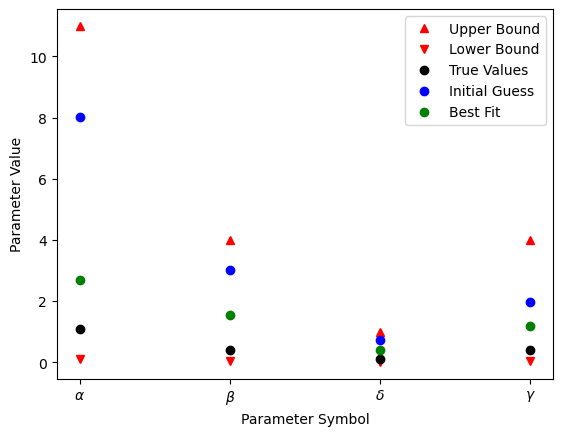

In [16]:
param_labels = ["$\\alpha$", "$\\beta$", "$\\delta$", "$\gamma$"]
orig_mod = model()
true_vals = [orig_mod.a, orig_mod.b, orig_mod.d, orig_mod.g]

plt.plot(param_labels, ub, 'r^', label='Upper Bound')
plt.plot(param_labels, lb, 'rv', label='Lower Bound')
plt.plot(param_labels, true_vals, 'ko', label="True Values");
plt.plot(param_labels, init_params, 'bo', label="Initial Guess")
plt.plot(param_labels, best_params, 'go', label='Best Fit')
plt.legend();
plt.xlabel('Parameter Symbol'); plt.ylabel('Parameter Value');

#### Plot fits to synthetic dataset

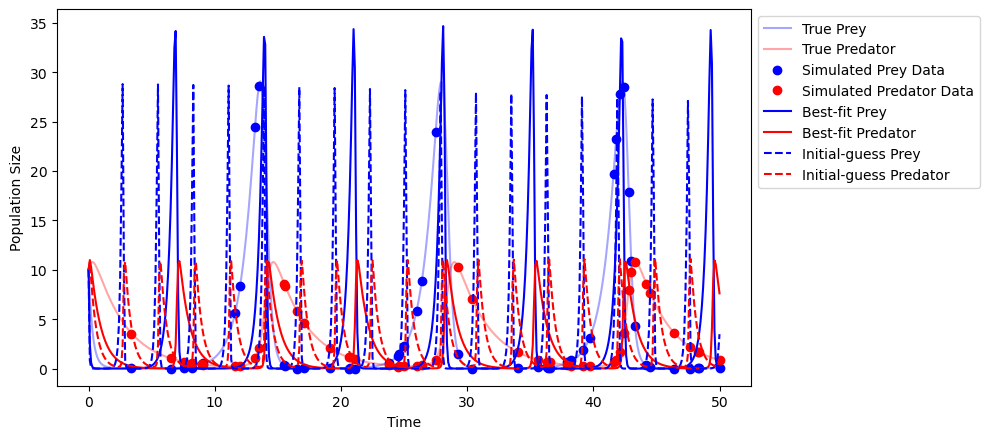

In [17]:
plt.figure(figsize=(10,4.5))

# plot true solution
orig_mod = model()
orig_ts, orig_res = orig_mod.solve_sys()
plt.plot(orig_ts, orig_res[:, 0], 'b-', label="True Prey", alpha=0.35)
plt.plot(orig_ts, orig_res[: ,1], 'r-', label="True Predator", alpha=0.35)

# Plot synthetic data
plt.plot(ts_data, res_noisy[:, 0], 'bo', label='Simulated Prey Data')
plt.plot(ts_data, res_noisy[:, 1], 'ro',label='Simulated Predator Data')

# plot Best fit
plt.plot(best_ts, best_traj[: ,0], 'b-', label='Best-fit Prey')
plt.plot(best_ts, best_traj[:, 1], 'r-', label='Best-fit Predator')

# plot initial guess
plt.plot(init_ts, init_traj[: ,0], 'b--', label='Initial-guess Prey')
plt.plot(init_ts, init_traj[:, 1], 'r--', label='Initial-guess Predator')


plt.xlabel('Time'); plt.ylabel('Population Size')
plt.margins(x=0.05, y=0.05); plt.legend(bbox_to_anchor=([1.0,1.0]));
#plt.title('Original Solution: $\\alpha={}$, $\\beta={}$, $\delta={}$, $\gamma={}$ with \nSimulated Data with {:.2f}% Gaussian Noise'.format(mod.a, mod.b, mod.d, mod.g, pct*100))
plt.tight_layout();

### Plot MCMC sampling results

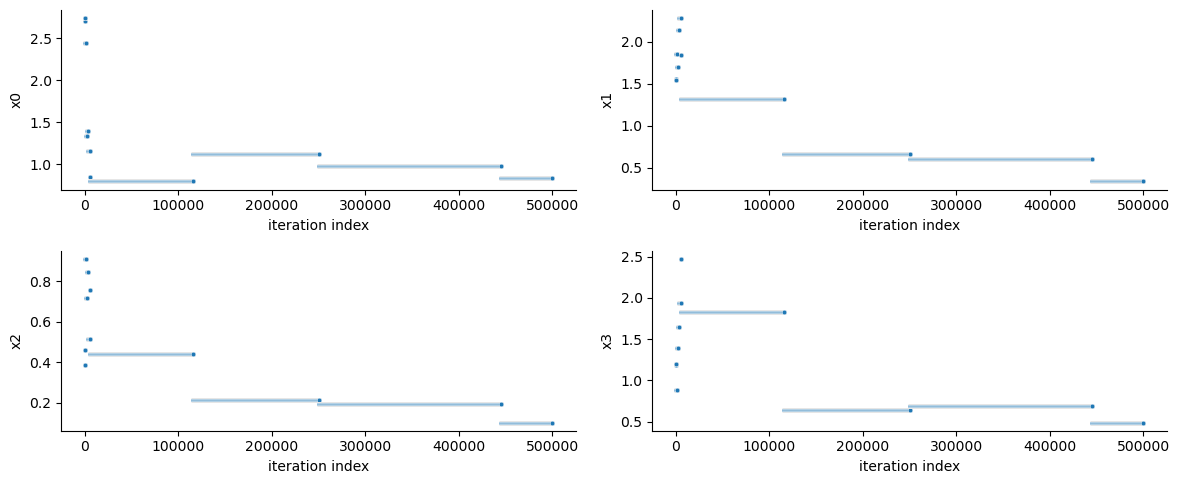

In [18]:
ax = visualize.sampling_parameter_traces(
    result, use_problem_bounds=False, size=(12, 5)
)

In [19]:
posterior = result.sample_result['trace_neglogpost'][0]
print(posterior.shape)

(500001,)


Text(0.5, 0, 'MCMC Iteration')

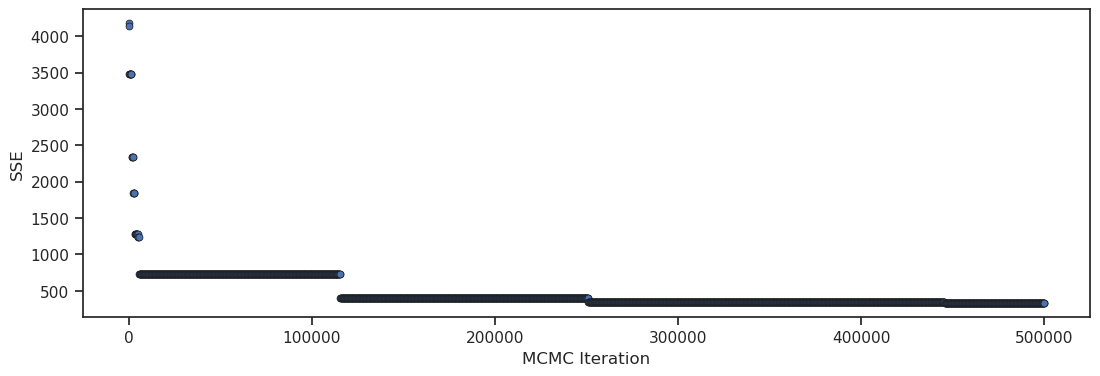

In [20]:
STEP = 200
plt.figure(figsize=(13,4));
plt.plot(np.arange(1,posterior.shape[0]+1)[::STEP], posterior[::STEP], 'bo', markersize=5, markeredgecolor='k', markeredgewidth=0.5)
plt.ylabel('SSE'); plt.xlabel('MCMC Iteration')

In [21]:
print(np.min(posterior))

329.3430223328318
